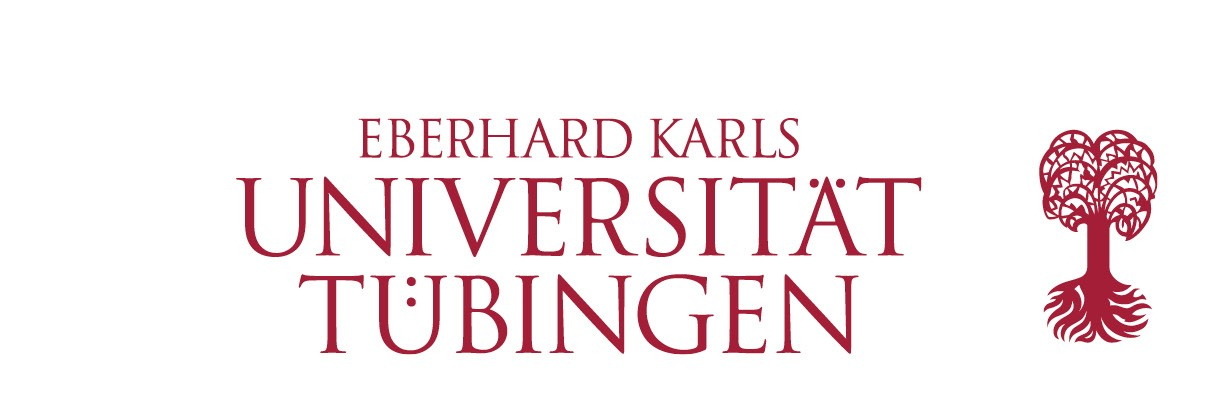

# **Computational Immunomics 2023**

Interfakultäres Institut für Biomedizinische Informatik (IBMI)

Prof. Dr. Oliver Kohlbacher

Tutors:
Alexander Röhl, Matteo Pilz

ci-ss23@informatik.uni-tuebingen.de

# **INFORMATION**

You should work in groups of 3 to 4 on the project, please write your names here:
1. \<name_1\>
2. \<name_2\>
3. \<name_3\>
4. \<name_4\>

You are allowed to write in german or english.
Your hand in should be zipped and the archive should follow the naming convention: 
project_\<name_1\>_\<name_2\>_\<name_3\>_\<name_4\>.zip\
Example: project_weber_mueller_muster_sommer.zip

Finally, upload your zip file containing all important files to ILIAS.

Tip: You can use some LaTex commands (rendered with MathJax) in math mode: $\alpha$

# **Project (100P + 5BP) - Hand In: Thursday July 20, 11:55 pm**

This project applies the practical knowledge you gained on machine learning during the lecture and the assignments of this course.
Your task is to implement a MHC I-binding predictor with a prediction as accurate as possible. You may thereby use any method, model, or strategy, which you implemented using any python library.
However, you are not allowed to simply load in and use an existing predictor. Copying the code from one is also not allowed and will, without citation, be counted as plagiarism. You are free to **adopt** existing implementations (please cite accordingly) and orientate yourself on published models regarding structure and parameters.

Feel free to also make use of the following potential work plan.

## <h2><center>Dates \& Potential Work Plan</center></h2>

| **Date**         | **Task**                                                                                                          |
|------------------|-------------------------------------------------------------------------------------------------------------------|
| June 13 - Week 1 | **Project handout**, research / familiarize yourself with the Python libraries                                    |
| June 20          | **[Group assignment](#group_assignment) 11:55 pm**, Assign yourself to one of the groups in ILIAS                 |
| June 22 - Week 2 | Choose an appropriate [encoding](#encoding)                                                                       |
| June 29 - Week 3 | Create [model](#model) drafts                                                                                     |
| July 06 - Week 4 | [Optimize](#optimization) your model by using a cross-validation pipeline                                         |
| July 13 - Week 5 | Finish the [optimization](#optimization), write the [prediction output](#output) function & write-up your project |
| July 20 - Week 6 | **Project handin 11:55 pm**, prepare presentation                                                                 |
| July 27          | **[Project presentation](#presentation)**                                                                         |
| August 03        | **Written exam**                                                                                                  |

<a id='group_assignment'></a>

## **Group Assignment - Tuesday June 20, 11:55 pm**
Assign yourself to one of the groups in the Computational Immunomics workspace in ILIAS under */Exercises/Project*. Make sure you and the rest of your group assign yourself to the same group. Joining and leaving a group in ILIAS is possible until Tuesday June 20 11:55 pm.

---
## **1. Input**
You are given a dataset with labeled datapoints as training data in `ci_project_data.csv`. The dataset contains four columns: `sequence`, `label`, `length` and `affinity`. The labels are `0 == non binder` and `1 == binder` (classification), the `affinity` is the binding affinity from 0-1, which you may use as an alternative (regression). Use this data wisely in order to fulfill the requirements of the project. At the end, make sure that your selected model is trained on the full dataset \*, before you use it for prediction.

### **Bonus (5BP)**
\* The dataset does not only contain peptides with length 9, but also shorter and longer ones. Find a suitable way to encode these peptides (in [2. Encoding](#encoding)) and use them in your training, too. If you don't want to do this task, you can simply filter out all peptides that do not have length 9 (the remaining number of sequences should be 7176).

In [27]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
import matplotlib.pyplot as plt
np.random.seed(1)

In [28]:
project_data = pd.read_csv('ci_project_train.csv')

project_data


,sequence,label,length,affinity
0,SVFNSLYA,0,8,0.419718
1,YLIRALTL,0,8,0.407692
2,FLTGYLQL,0,8,0.401746
3,ALQLLLEV,0,8,0.399727
4,VLFQNWGI,0,8,0.376714
...,...,...,...,...
9649,ALTSLGLLYT,1,10,0.448816
9650,ITLLCLIPTV,1,10,0.437257
9651,RLHKECLLRL,1,10,0.436015
9652,AITLVVISVI,1,10,0.426713


In [29]:
project_data = project_data[(project_data['length'] >= 8) & (project_data['length'] <= 10)].reset_index(drop=True)
for index, row in project_data.iterrows():
    sequence_l = row['sequence']
    if len(sequence_l) == 10:
        project_data.at[index, 'sequence'] = sequence_l[:-1]

# TODO: length does not update
project_data

,sequence,label,length,affinity
0,SVFNSLYA,0,8,0.419718
1,YLIRALTL,0,8,0.407692
2,FLTGYLQL,0,8,0.401746
3,ALQLLLEV,0,8,0.399727
4,VLFQNWGI,0,8,0.376714
...,...,...,...,...
9495,TINCDVGYE,1,10,0.449826
9496,ALTSLGLLY,1,10,0.448816
9497,ITLLCLIPT,1,10,0.437257
9498,RLHKECLLR,1,10,0.436015


In [ ]:
#project_data = project_data.loc[project_data['length'] == 9]
#project_data = project_data.reset_index(drop=True)

<a id='encoding'></a>

---
## **2. Encoding**
Explain how you encode your data, so that the model is able to return meaningful predictions. If you use an encoding from an existing source, which we encourage, make sure to properly cite it. We also encourage you to prepare multiple different encodings and compare their results later.


...

In [33]:
# One-Hot Encoding

amino_acid_df = pd.DataFrame([
    ['Glycine', 'GLY', 'G'],
    ['Alanine', 'ALA', 'A'],
    ['Valine', 'VAL', 'V'],
    ['Leucine', 'LEU', 'L'],
    ['IsoLeucine', 'ILE', 'I'],
    ['Threonine', 'THR', 'T'],
    ['Serine', 'SER', 'S'],
    ['Methionine', 'MET', 'M'],
    ['Cystein', 'CYS', 'C'],
    ['Proline', 'PRO', 'P'],
    ['Phenylalanine', 'PHE', 'F'],
    ['Tyrosine', 'TYR', 'Y'],
    ['Tryptophane', 'TRP', 'W'],
    ['Histidine', 'HIS', 'H'],
    ['Lysine', 'LYS', 'K'],
    ['Argenine', 'ARG', 'R'],
    ['Aspartate', 'ASP', 'D'],
    ['Glutamate', 'GLU', 'E'],
    ['Asparagine', 'ASN', 'N'],
    ['Glutamine', 'GLN', 'Q']
], columns=['Amino Acids', 'Three Letter Code', 'Single Letter Code'])

amino_acid_df_sorted = amino_acid_df.sort_values(by=['Single Letter Code'])

def encode_aa(aa):
    return [1 if aa == amino_acid_df_sorted['Single Letter Code'].iloc[i] else 0 for i in range(20)]
def encode_prot(prot):
    return [bit for aa in prot for bit in encode_aa(aa)]

def encode_data(elements):
    encoded_elements = []
    for row in elements:
        encoded_elements.append(encode_prot(row))
    return encoded_elements


#X_train = np.array(encode_data(project_data['sequence']))




In [19]:
# Blomap Encoding

# Source: https://www.researchgate.net/figure/Code-vectors-for-the-BLOMAP-encoding-in-five-dimensions_tbl1_27468320
# Table 1: by Stefan Renard Maetschke
# Dimension = biochemical properties or features of amino acids
blomap_matrix = pd.DataFrame({
    'A': [-.57, .39, -.96, -.61, -.69],
    'C': [.07, 2.04, .65, -1.13, -.39],
    'D': [-1.62, -0.52, -0.67, 1.02, 1.47],
    'E': [-0.64, -1.59, -.39, .69, 1.04],
    'F': [1.87, 1.04, 1.28, -.61, -.16],
    'G': [-.90, .87, -0.36, 1.08, 1.95],
    'H': [0.73, -0.67, -0.42, 1.13, 0.99],
    'I': [0.59, .79, 1.44, -1.90, -.93],
    'K': [-.64, -1.19, -.65, .68, -.13],
    'L': [.65, .84, 1.25, -.99, -1.90],
    'M': [.76, .05, .06, -.62, -1.59],
    'N': [-.70, -.63, -1.47, 1.02, 1.06],
    'P': [-1.82, -0.63, .32, .03, .68],
    'Q': [-.05, -1.50, -.67, .49, .21],
    'R': [-.40, -0.83, -0.61, 1.26, -0.28],
    'S': [-.39, -.27, -1.51, -.25, .31],
    'T': [-.04, -.30, -.82, -1.02, -.04],
    'V': [-.02, 0.30, .97, -1.55, -1.16],
    'W': [1.38, 1.69, 1.91, 1.07, -.05],
    'Y': [-.02, .30, .97, -1.55, -1.16]
})


def blomap_encode(sequence):
    encoded_sequence = []
    if len(sequence) == 8:
        encoded_sequence.extend([0.0] * 5)
    for aa in sequence:
        if aa in blomap_matrix.columns:
            encoded_sequence.extend(blomap_matrix[aa])
    return encoded_sequence

def blomap_encode_df(df):
    encoded_sequences_f = []
    for sequence in df:
        encoded_sequences_f.append(blomap_encode(sequence))
    return pd.DataFrame({"encoded_sequences": encoded_sequences_f}, columns=['encoded_sequences'])
    #return encoded_sequences_f


In [20]:
blomap_encoded_sequences = blomap_encode_df(project_data['sequence'])
blomap_encoded_df = pd.concat([blomap_encoded_sequences, project_data], axis=1)
blomap_encoded_df
#X_train = np.array(blomap_encode_df(project_data['sequence']))

In [35]:
#X_train = [np.array(blomap_encoded_df['encoded_sequences'][i]) for i in range(len(blomap_encoded_df['encoded_sequences']))]
X_train = np.array(encode_data(project_data['sequence']))
X_train

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9500,) + inhomogeneous part.

In [22]:
# Split into training/test/validation
features = X_train
features
#features
targets = project_data['label'].to_numpy()
#targets


In [23]:
X_train, X_val_test, y_train, y_val_test = train_test_split(features, targets, stratify=targets, train_size=0.7, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, stratify=y_val_test, train_size=0.5, random_state=1)
X_train

array([[-0.02,  0.3 ,  0.97, ...,  0.97, -1.55, -1.16],
       [ 0.65,  0.84,  1.25, ...,  0.97, -1.55, -1.16],
       [-0.04, -0.3 , -0.82, ...,  1.25, -0.99, -1.9 ],
       ...,
       [-0.9 ,  0.87, -0.36, ..., -0.65,  0.68, -0.13],
       [-0.9 ,  0.87, -0.36, ...,  0.97, -1.55, -1.16],
       [-0.02,  0.3 ,  0.97, ...,  0.06, -0.62, -1.59]])

<a id='model'></a>

---
## **3. Machine Learning Model**
Select at least one machine learning algorithm, which you'd like to apply your following tests on. Explain why you chose those algorithms. Note: It may be beneficial to set up multiple different models and test their performance for your task, even if you end up using only one at the end.

...

In [24]:
from sklearn import svm
#Create an SVM classifier
clf = svm.SVC()
#clf.fit(X_train, y_train)
#clf.score(X_test, y_test)


<a id='optimization'></a>

---
## **4. Optimization & Validation**
Write a cross-validation pipeline, with suitable metrics to test the performance of your model. Then integrate the optimization of the parameters for your model(s). Explain why you decided to tune these hyperparameters with their specific values. For example: We learned in detail how specifying certain parameters in SVMs impact their training process, such as their kernel function or the value of the parameter $C$.

...

In [25]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # The regularization parameter
    'kernel': ['linear', 'rbf','sigmoid'],  # The kernel function to use
    'gamma': [0.1, 1, 10]  #  Kernel coefficient for 'rbf' and 'sigmoid' kernels
}

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best SVM classifier with optimized hyperparameters
best_svm_classifier = grid_search.best_estimator_

# Evaluate the best classifier on the validation set
y_val_pred = best_svm_classifier.predict(X_val)

# Evaluate the best classifier using k-fold cross-validation
cv_scores_accuracy = cross_val_score(best_svm_classifier, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_precision = cross_val_score(best_svm_classifier, X_train, y_train, cv=5, scoring='precision')
cv_scores_recall = cross_val_score(best_svm_classifier, X_train, y_train, cv=5, scoring='recall')
cv_scores_f1 = cross_val_score(best_svm_classifier, X_train, y_train, cv=5, scoring='f1')
cv_scores_auc_roc = cross_val_score(best_svm_classifier, X_train, y_train, cv=5, scoring='roc_auc')

# Print the results of k-fold cross-validation
print("Best SVM classifier:", best_svm_classifier)
print("Accuracy (CV):", cv_scores_accuracy.mean())
print("Precision (CV):", cv_scores_precision.mean())
print("Recall (CV):", cv_scores_recall.mean())
print("F1-score (CV):", cv_scores_f1.mean())
print("AUC-ROC (CV):", cv_scores_auc_roc.mean())

# Best Model with One-Hot Encoding without padded data
# SVC(C=1, gamma=0.1, kernel='linear') -> Test Accuracy: 0.8857938718662952
# 
# Best Model with Blomap Encoding and padded data
# SVC(C=10, gamma=0.1, kernel='linear') -> Test Accuracy: 0.8007017543859649; Test ROC-AUC: 0.7779791060040655



Best SVM classifier: SVC(C=10, gamma=0.1, kernel='linear')
Accuracy (CV): 0.8022556390977444
Precision (CV): 0.736240381941452
Recall (CV): 0.7248671203616313
F1-score (CV): 0.7304227308279648
AUC-ROC (CV): 0.872478710392777


In [26]:
# Evaluate the best classifier on the testing set
y_test_pred = best_svm_classifier.predict(X_test)

# Calculate evaluation metrics for the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

# Print the results for the testing set
print("Testing Accuracy:", test_accuracy)
print("Testing Classification Report:\n", test_classification_report)
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred))


Testing Accuracy: 0.8007017543859649
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       898
           1       0.75      0.69      0.72       527

    accuracy                           0.80      1425
   macro avg       0.79      0.78      0.78      1425
weighted avg       0.80      0.80      0.80      1425

AUC-ROC: 0.7779791060040655


In [13]:
# Train the best SVM classifier on the whole training set
best_svm_classifier.fit(X_train, y_train)
best_svm_classifier.score(X_test, y_test)




0.8007017543859649

<a id='output'></a>

---
## **5. Output**
The `predict` function below should contain a pipeline from a numpy array input of peptide sequences (`np.array` of `str`) to an `np.array` of predicted labels of `0` or `1`. In case you have been using `affinity` instead, make sure to set a suitable threshold for your prediction (output should be `0` or `1`). Therefore, the function should use your encoding, feed it into your model and output its result. You can test your function with the `test_sequences` below. The performance of your model will have a slight impact on your grading of your project as well (tested with a separate dataset). We will also release a ranking of all groups and their placement against each other.

**NOTE:** Before the call of the `predict` function, your model should have been trained already. Please do not include the training of the model in it.

In [14]:
test_df = pd.read_csv('ci_project_test_sample.csv')
test_sequences = test_df['sequence'].to_numpy()
test_sequences = np.array(encode_data(test_sequences))
test_sequences

NameError: name 'encode_data' is not defined

In [63]:
def predict(classifier: object, sequences: np.array) -> np.array:
    '''
    Predicts the binder label for a numpy array of sequences (0 for non-binder, 1 for binder).

            Parameters:
                    classifier (object): your classifier
                    sequences (np.array): Sequences array

            Returns:
                    A numpy array containing the binary decisions of all sequences
    '''
    
    return np.array(best_svm_classifier.predict(sequences))  # TODO: replace this with your model's prediction


help(predict)
predict(object, test_sequences)

Help on function predict in module __main__:

predict(classifier: object, sequences: <built-in function array>) -> <built-in function array>
    Predicts the binder label for a numpy array of sequences (0 for non-binder, 1 for binder).
    
            Parameters:
                    classifier (object): your classifier
                    sequences (np.array): Sequences array
    
            Returns:
                    A numpy array containing the binary decisions of all sequences



array([0, 1, 1, 0, 1, 0], dtype=int64)

<a id='presentation'></a>

---
---
# **7. Presentation - Thursday the 27th of July**
After handing in your project, you have one week to prepare a short 7-10min presentation (we'll have to stop you at 10 minutes). The presentations will be held by all groups on Thursday the 27th of July during the lecture.